In [1]:
# Import standard libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import logging

# Suppress logs from cmdstanpy
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Suppress logs from prophet
logging.getLogger('prophet').setLevel(logging.WARNING)

# Optionally, suppress other libraries if they are also too verbose
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('seaborn').setLevel(logging.WARNING)



# Import the flight_forecasting module
import flight_forecasting as ff

# For displaying plots within the notebook
%matplotlib inline

# Optional: Set Seaborn style for better aesthetics
sns.set_theme()


## Flight Data Import
List all the CSV filenames corresponding to different origin airports. Ensure that these files are present in the `INPUT_DIR` specified in `flight_forecasting.py`.

In [2]:
# List of CSV filenames corresponding to different origin airports
CSV_FILES = [
    'Origin Airport Baltimore, MD BaltimoreWashington International Thurgood Marshall (BWI).csv',
    'Origin Airport Chicago, IL Chicago Midway International (MDW).csv',
    'Origin Airport Dallas, TX Dallas Love Field (DAL).csv',
    'Origin Airport Denver, CO Denver International (DEN).csv',
    'Origin Airport Las Vegas, NV Harry Reid International (LAS).csv'
]

# Update the flight_forecasting module's CSV_FILES if necessary
ff.CSV_FILES = CSV_FILES

## Processing and Forecasting

- Load each CSV file, clean the data by handling missing values, and filter for the specified month (June by default).
- Aggregate the number of flights per year for the specified month.
- Iterate through each CSV file, perform forecasting using various models, evaluate their performance, and visualize the results.
  - Forecasting Models tested:
    - ARIMA
    - Exponential Smoothing
    - Linear Regression
    - Naive Forecast
    - Prophet


Processing Airport: Baltimore, MD BaltimoreWashington International Thurgood Marshall (BWI)
Loaded data from D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Data/Origin Airport Baltimore, MD BaltimoreWashington International Thurgood Marshall (BWI).csv successfully.

First few rows of the cleaned DataFrame:


,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Date,Month,Year
0,WN,6/1/2003,85.0,N431,LAX,17:45,17:50,380.0,325.0,5.0,18:00,10.0,0.0,0.0,0.0,0.0,0.0,2003-06-01,6,2003
1,WN,6/1/2003,846.0,N410,LAX,9:40,10:00,380.0,315.0,20.0,10:07,7.0,0.0,0.0,0.0,0.0,0.0,2003-06-01,6,2003
2,WN,6/1/2004,85.0,N438,LAX,17:50,19:33,355.0,325.0,103.0,19:43,10.0,9.0,0.0,0.0,0.0,64.0,2004-06-01,6,2004
3,WN,6/1/2004,285.0,N709SW,SAN,19:10,20:35,355.0,315.0,85.0,20:44,9.0,3.0,0.0,0.0,0.0,42.0,2004-06-01,6,2004
4,WN,6/1/2004,590.0,N453,SAN,11:05,11:05,355.0,335.0,0.0,11:18,13.0,0.0,0.0,0.0,0.0,0.0,2004-06-01,6,2004



Complete Flights Per Year (June only):


,Year,Number_of_Flights
0,2000,0
1,2001,0
2,2002,0
3,2003,60
4,2004,122
5,2005,120
6,2006,120
7,2007,120
8,2008,90
9,2009,99



Processing Year: 2001
Exponential Smoothing failed for year 2001: index 1 is out of bounds for axis 0 with size 1
Prophet model failed for year 2001: Dataframe has less than 2 non-NaN rows.

Processing Year: 2002
ARIMA model failed for year 2002: too many indices for array: array is 0-dimensional, but 1 were indexed

Processing Year: 2003


23:35:11 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2004

Processing Year: 2005


23:35:11 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1] done processing
23:35:11 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2006

Processing Year: 2007


23:35:11 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1] done processing
23:35:11 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2008

Processing Year: 2009


23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2010

Processing Year: 2011


23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2012

Processing Year: 2013


23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2014

Processing Year: 2015


23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:13 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2016

Processing Year: 2017


23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:13 - cmdstanpy - INFO - Chain [1] done processing
23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:13 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2018

Processing Year: 2019


23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:13 - cmdstanpy - INFO - Chain [1] done processing
23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:13 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2020

Processing Year: 2021


23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:13 - cmdstanpy - INFO - Chain [1] done processing
23:35:14 - cmdstanpy - INFO - Chain [1] start processing
23:35:14 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2022

Processing Year: 2023


23:35:14 - cmdstanpy - INFO - Chain [1] start processing
23:35:14 - cmdstanpy - INFO - Chain [1] done processing
23:35:14 - cmdstanpy - INFO - Chain [1] start processing
23:35:14 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2024

Forecasting Results:


,Year,Model,Predicted,Actual,MAE,RMSE
0,2001.0,Naïve Forecast,0.0,0.0,0.0,0.0
1,2001.0,Linear Regression,0.0,0.0,0.0,0.0
2,2001.0,"ARIMA(1,1,1)",0.0,0.0,0.0,0.0
3,2001.0,Exponential Smoothing,NaN,0.0,NaN,NaN
4,2001.0,Prophet,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...
115,2024.0,Naïve Forecast,278.0,375.0,97.0,97.0
116,2024.0,Linear Regression,406.0,375.0,31.0,31.0
117,2024.0,"ARIMA(1,1,1)",307.0,375.0,68.0,68.0
118,2024.0,Exponential Smoothing,299.0,375.0,76.0,76.0



Model Performance Summary:


,Model,MAE,RMSE
0,"ARIMA(1,1,1)",51.086957,51.086957
1,Exponential Smoothing,63.347826,63.347826
2,Linear Regression,58.833333,58.833333
3,Naïve Forecast,42.458333,42.458333
4,Prophet,61.652174,61.652174



Best Model for Baltimore, MD BaltimoreWashington International Thurgood Marshall (BWI): Naïve Forecast with RMSE = 42.46

Forecasting 2025 for Baltimore, MD BaltimoreWashington International Thurgood Marshall (BWI) using Naïve Forecast...

2025 Predicted Flights for Baltimore, MD BaltimoreWashington International Thurgood Marshall (BWI): 375
Forecast results saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Baltimore, MD BaltimoreWashington International Thurgood Marshall (BWI)\Baltimore, MD BaltimoreWashington International Thurgood Marshall (BWI)_Forecast_Results.csv
Performance summary saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Baltimore, MD BaltimoreWashington International Thurgood Marshall (BWI)\Baltimore, MD BaltimoreWashington International Thurgood Marshall (BWI)_Performance_Summary.csv
RMSE plot saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Baltimore, MD BaltimoreWashington International Thurgood Marshall (BWI)\Baltimore, MD Baltimore

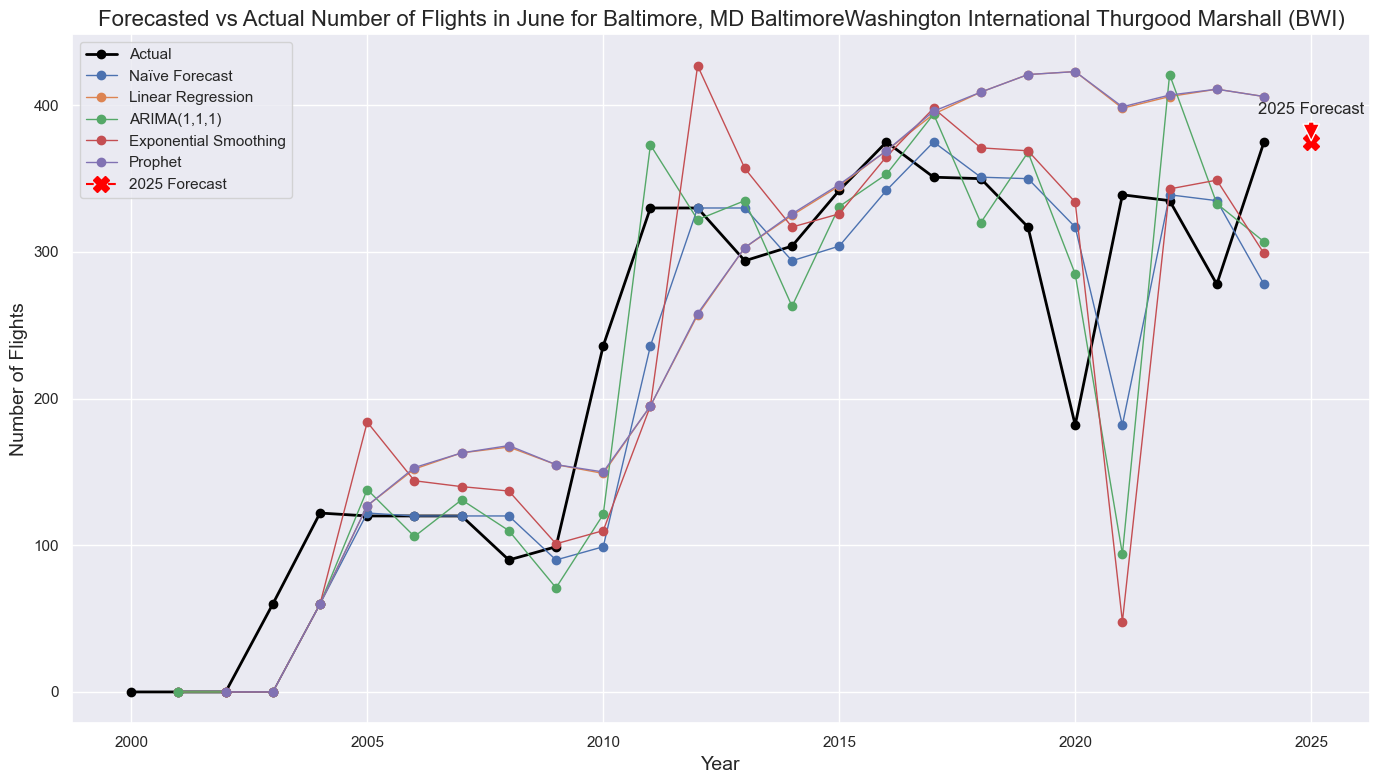

Model Performance Summary:


,Model,MAE,RMSE
0,"ARIMA(1,1,1)",51.086957,51.086957
1,Exponential Smoothing,63.347826,63.347826
2,Linear Regression,58.833333,58.833333
3,Naïve Forecast,42.458333,42.458333
4,Prophet,61.652174,61.652174





Processing Airport: Chicago, IL Chicago Midway International (MDW)
Loaded data from D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Data/Origin Airport Chicago, IL Chicago Midway International (MDW).csv successfully.

First few rows of the cleaned DataFrame:


,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Date,Month,Year
0,WN,6/1/2002,1062.0,N716,SEA,17:40,18:00,270.0,255.0,20.0,18:10,10.0,0.0,0.0,0.0,0.0,0.0,2002-06-01,6,2002
1,WN,6/1/2002,1411.0,N716,SEA,8:15,8:25,270.0,255.0,10.0,8:33,8.0,0.0,0.0,0.0,0.0,0.0,2002-06-01,6,2002
2,WN,6/1/2002,1516.0,N782,LAX,7:15,7:15,270.0,263.0,0.0,7:25,10.0,0.0,0.0,0.0,0.0,0.0,2002-06-01,6,2002
3,WN,6/1/2002,1695.0,N777,LAX,13:20,13:25,270.0,245.0,5.0,13:35,10.0,0.0,0.0,0.0,0.0,0.0,2002-06-01,6,2002
4,WN,6/1/2002,2873.0,N782,LAX,16:50,17:03,270.0,262.0,13.0,17:10,7.0,0.0,0.0,0.0,0.0,0.0,2002-06-01,6,2002



Complete Flights Per Year (June only):


,Year,Number_of_Flights
0,2000,0
1,2001,0
2,2002,216
3,2003,240
4,2004,274
5,2005,392
6,2006,416
7,2007,480
8,2008,510
9,2009,438



Processing Year: 2001
Exponential Smoothing failed for year 2001: index 1 is out of bounds for axis 0 with size 1
Prophet model failed for year 2001: Dataframe has less than 2 non-NaN rows.

Processing Year: 2002
ARIMA model failed for year 2002: too many indices for array: array is 0-dimensional, but 1 were indexed

Processing Year: 2003


23:35:15 - cmdstanpy - INFO - Chain [1] start processing
23:35:15 - cmdstanpy - INFO - Chain [1] done processing
23:35:15 - cmdstanpy - INFO - Chain [1] start processing
23:35:15 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2004

Processing Year: 2005


23:35:15 - cmdstanpy - INFO - Chain [1] start processing
23:35:15 - cmdstanpy - INFO - Chain [1] done processing
23:35:15 - cmdstanpy - INFO - Chain [1] start processing
23:35:15 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2006

Processing Year: 2007


23:35:16 - cmdstanpy - INFO - Chain [1] start processing
23:35:16 - cmdstanpy - INFO - Chain [1] done processing
23:35:16 - cmdstanpy - INFO - Chain [1] start processing
23:35:16 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2008

Processing Year: 2009


23:35:16 - cmdstanpy - INFO - Chain [1] start processing
23:35:16 - cmdstanpy - INFO - Chain [1] done processing
23:35:16 - cmdstanpy - INFO - Chain [1] start processing
23:35:16 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2010

Processing Year: 2011


23:35:16 - cmdstanpy - INFO - Chain [1] start processing
23:35:16 - cmdstanpy - INFO - Chain [1] done processing
23:35:16 - cmdstanpy - INFO - Chain [1] start processing
23:35:16 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2012

Processing Year: 2013


23:35:17 - cmdstanpy - INFO - Chain [1] start processing
23:35:17 - cmdstanpy - INFO - Chain [1] done processing
23:35:17 - cmdstanpy - INFO - Chain [1] start processing
23:35:17 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2014

Processing Year: 2015


23:35:17 - cmdstanpy - INFO - Chain [1] start processing
23:35:17 - cmdstanpy - INFO - Chain [1] done processing
23:35:17 - cmdstanpy - INFO - Chain [1] start processing
23:35:17 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2016

Processing Year: 2017


23:35:17 - cmdstanpy - INFO - Chain [1] start processing
23:35:17 - cmdstanpy - INFO - Chain [1] done processing
23:35:17 - cmdstanpy - INFO - Chain [1] start processing
23:35:17 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2018

Processing Year: 2019


23:35:18 - cmdstanpy - INFO - Chain [1] start processing
23:35:18 - cmdstanpy - INFO - Chain [1] done processing
23:35:18 - cmdstanpy - INFO - Chain [1] start processing
23:35:18 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2020

Processing Year: 2021


23:35:18 - cmdstanpy - INFO - Chain [1] start processing
23:35:18 - cmdstanpy - INFO - Chain [1] done processing
23:35:18 - cmdstanpy - INFO - Chain [1] start processing
23:35:18 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2022

Processing Year: 2023


23:35:18 - cmdstanpy - INFO - Chain [1] start processing
23:35:18 - cmdstanpy - INFO - Chain [1] done processing
23:35:18 - cmdstanpy - INFO - Chain [1] start processing
23:35:18 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2024

Forecasting Results:


,Year,Model,Predicted,Actual,MAE,RMSE
0,2001.0,Naïve Forecast,0.0,0.0,0.0,0.0
1,2001.0,Linear Regression,0.0,0.0,0.0,0.0
2,2001.0,"ARIMA(1,1,1)",0.0,0.0,0.0,0.0
3,2001.0,Exponential Smoothing,NaN,0.0,NaN,NaN
4,2001.0,Prophet,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...
115,2024.0,Naïve Forecast,899.0,819.0,80.0,80.0
116,2024.0,Linear Regression,1014.0,819.0,195.0,195.0
117,2024.0,"ARIMA(1,1,1)",916.0,819.0,97.0,97.0
118,2024.0,Exponential Smoothing,933.0,819.0,114.0,114.0



Model Performance Summary:


,Model,MAE,RMSE
0,"ARIMA(1,1,1)",87.000000,87.000000
1,Exponential Smoothing,104.521739,104.521739
2,Linear Regression,117.291667,117.291667
3,Naïve Forecast,87.541667,87.541667
4,Prophet,122.565217,122.565217



Best Model for Chicago, IL Chicago Midway International (MDW): ARIMA(1,1,1) with RMSE = 87.00

Forecasting 2025 for Chicago, IL Chicago Midway International (MDW) using ARIMA(1,1,1)...

2025 Predicted Flights for Chicago, IL Chicago Midway International (MDW): 800
Forecast results saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Chicago, IL Chicago Midway International (MDW)\Chicago, IL Chicago Midway International (MDW)_Forecast_Results.csv
Performance summary saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Chicago, IL Chicago Midway International (MDW)\Chicago, IL Chicago Midway International (MDW)_Performance_Summary.csv
RMSE plot saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Chicago, IL Chicago Midway International (MDW)\Chicago, IL Chicago Midway International (MDW)_Average_RMSE.png
MAE plot saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Chicago, IL Chicago Midway International (MDW)\Chicago, IL Chicago Midway International (MDW)_

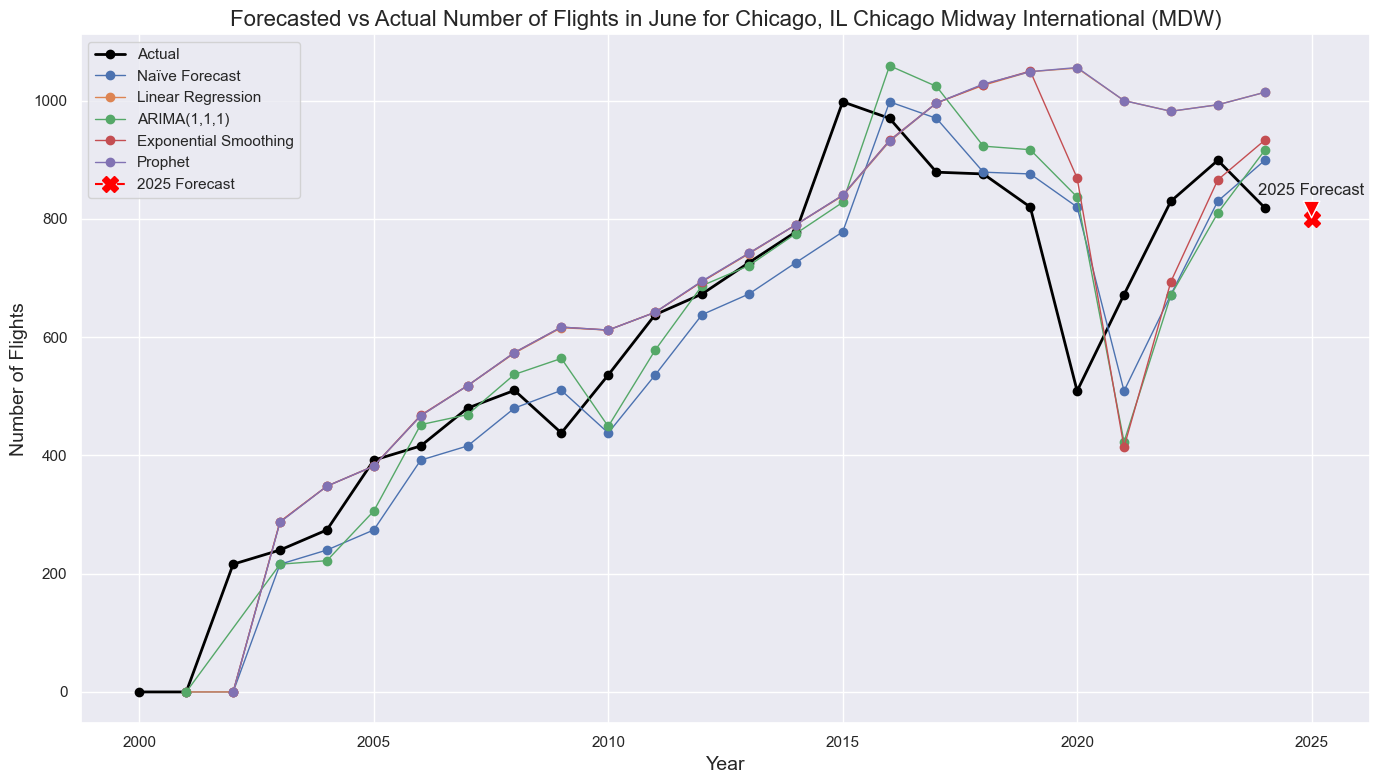

Model Performance Summary:


,Model,MAE,RMSE
0,"ARIMA(1,1,1)",87.000000,87.000000
1,Exponential Smoothing,104.521739,104.521739
2,Linear Regression,117.291667,117.291667
3,Naïve Forecast,87.541667,87.541667
4,Prophet,122.565217,122.565217





Processing Airport: Dallas, TX Dallas Love Field (DAL)
Loaded data from D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Data/Origin Airport Dallas, TX Dallas Love Field (DAL).csv successfully.

First few rows of the cleaned DataFrame:


,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Date,Month,Year
0,WN,6/1/2000,14.0,N625,OKC,10:45,10:45,45.0,44.0,0.0,10:51,6.0,0.0,0.0,0.0,0.0,0.0,2000-06-01,6,2000
1,WN,6/1/2000,44.0,N702,OKC,18:15,18:15,45.0,39.0,0.0,18:21,6.0,0.0,0.0,0.0,0.0,0.0,2000-06-01,6,2000
2,WN,6/1/2000,130.0,N59,OKC,15:40,15:43,45.0,41.0,3.0,15:49,6.0,0.0,0.0,0.0,0.0,0.0,2000-06-01,6,2000
3,WN,6/1/2000,238.0,N96,OKC,20:35,20:35,50.0,46.0,0.0,20:44,9.0,0.0,0.0,0.0,0.0,0.0,2000-06-01,6,2000
4,WN,6/1/2000,474.0,N378,OKC,8:35,8:35,50.0,45.0,0.0,8:42,7.0,0.0,0.0,0.0,0.0,0.0,2000-06-01,6,2000



Complete Flights Per Year (June only):


,Year,Number_of_Flights
0,2000,219
1,2001,212
2,2002,187
3,2003,192
4,2004,187
5,2005,136
6,2006,135
7,2007,136
8,2008,142
9,2009,142



Processing Year: 2001


23:35:19 - cmdstanpy - INFO - Chain [1] start processing


Exponential Smoothing failed for year 2001: index 1 is out of bounds for axis 0 with size 1
Prophet model failed for year 2001: Dataframe has less than 2 non-NaN rows.

Processing Year: 2002
ARIMA model failed for year 2002: too many indices for array: array is 0-dimensional, but 1 were indexed


23:35:20 - cmdstanpy - INFO - Chain [1] done processing
23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2003

Processing Year: 2004


23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing
23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:21 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2005

Processing Year: 2006


23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:21 - cmdstanpy - INFO - Chain [1] done processing
23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:21 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2007

Processing Year: 2008


23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:21 - cmdstanpy - INFO - Chain [1] done processing
23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:21 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2009

Processing Year: 2010


23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:21 - cmdstanpy - INFO - Chain [1] done processing
23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2011

Processing Year: 2012


23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing
23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2013

Processing Year: 2014


23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing
23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2015

Processing Year: 2016


23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing
23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2017

Processing Year: 2018


23:35:23 - cmdstanpy - INFO - Chain [1] start processing
23:35:23 - cmdstanpy - INFO - Chain [1] done processing
23:35:23 - cmdstanpy - INFO - Chain [1] start processing
23:35:23 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2019

Processing Year: 2020


23:35:23 - cmdstanpy - INFO - Chain [1] start processing
23:35:23 - cmdstanpy - INFO - Chain [1] done processing
23:35:23 - cmdstanpy - INFO - Chain [1] start processing
23:35:23 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2021

Processing Year: 2022


23:35:23 - cmdstanpy - INFO - Chain [1] start processing
23:35:23 - cmdstanpy - INFO - Chain [1] done processing
23:35:23 - cmdstanpy - INFO - Chain [1] start processing
23:35:23 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2023

Processing Year: 2024


23:35:24 - cmdstanpy - INFO - Chain [1] start processing
23:35:24 - cmdstanpy - INFO - Chain [1] done processing



Forecasting Results:


,Year,Model,Predicted,Actual,MAE,RMSE
0,2001.0,Naïve Forecast,219.0,212.0,7.0,7.0
1,2001.0,Linear Regression,219.0,212.0,7.0,7.0
2,2001.0,"ARIMA(1,1,1)",219.0,212.0,7.0,7.0
3,2001.0,Exponential Smoothing,NaN,212.0,NaN,NaN
4,2001.0,Prophet,NaN,212.0,NaN,NaN
...,...,...,...,...,...,...
115,2024.0,Naïve Forecast,567.0,584.0,17.0,17.0
116,2024.0,Linear Regression,560.0,584.0,24.0,24.0
117,2024.0,"ARIMA(1,1,1)",553.0,584.0,31.0,31.0
118,2024.0,Exponential Smoothing,567.0,584.0,17.0,17.0



Model Performance Summary:


,Model,MAE,RMSE
0,"ARIMA(1,1,1)",76.913043,76.913043
1,Exponential Smoothing,73.173913,73.173913
2,Linear Regression,86.333333,86.333333
3,Naïve Forecast,57.375000,57.375000
4,Prophet,90.000000,90.000000



Best Model for Dallas, TX Dallas Love Field (DAL): Naïve Forecast with RMSE = 57.38

Forecasting 2025 for Dallas, TX Dallas Love Field (DAL) using Naïve Forecast...

2025 Predicted Flights for Dallas, TX Dallas Love Field (DAL): 584
Forecast results saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Dallas, TX Dallas Love Field (DAL)\Dallas, TX Dallas Love Field (DAL)_Forecast_Results.csv
Performance summary saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Dallas, TX Dallas Love Field (DAL)\Dallas, TX Dallas Love Field (DAL)_Performance_Summary.csv
RMSE plot saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Dallas, TX Dallas Love Field (DAL)\Dallas, TX Dallas Love Field (DAL)_Average_RMSE.png
MAE plot saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Dallas, TX Dallas Love Field (DAL)\Dallas, TX Dallas Love Field (DAL)_Average_MAE.png
Predictions vs Actual plot saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Dallas, TX Dallas Love Fi

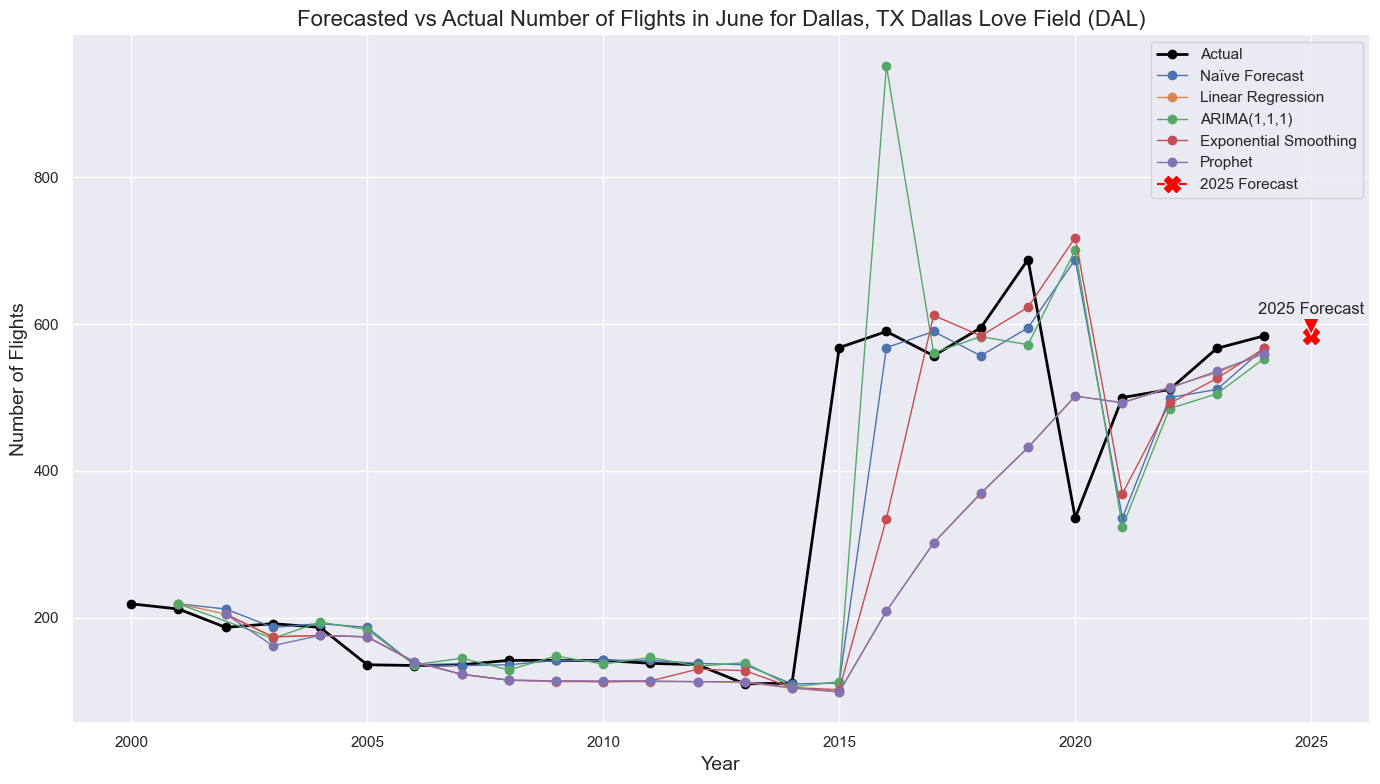

Model Performance Summary:


,Model,MAE,RMSE
0,"ARIMA(1,1,1)",76.913043,76.913043
1,Exponential Smoothing,73.173913,73.173913
2,Linear Regression,86.333333,86.333333
3,Naïve Forecast,57.375000,57.375000
4,Prophet,90.000000,90.000000





Processing Airport: Denver, CO Denver International (DEN)
Loaded data from D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Data/Origin Airport Denver, CO Denver International (DEN).csv successfully.

First few rows of the cleaned DataFrame:


,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Date,Month,Year
0,WN,6/1/2008,99.0,N629SW,SEA,19:40,19:35,175.0,174.0,-5.0,19:47,12.0,0.0,0.0,0.0,0.0,0.0,2008-06-01,6,2008
1,WN,6/1/2008,115.0,N509SW,LAX,21:10,21:08,145.0,151.0,-2.0,21:20,12.0,0.0,0.0,0.0,0.0,0.0,2008-06-01,6,2008
2,WN,6/1/2008,384.0,N207WN,SAN,14:55,14:53,145.0,147.0,-2.0,15:03,10.0,0.0,0.0,0.0,0.0,0.0,2008-06-01,6,2008
3,WN,6/1/2008,544.0,N623SW,SAN,21:00,21:04,145.0,143.0,4.0,21:11,7.0,0.0,0.0,0.0,0.0,0.0,2008-06-01,6,2008
4,WN,6/1/2008,1071.0,N369SW,LAX,15:05,15:06,145.0,151.0,1.0,15:16,10.0,0.0,0.0,0.0,0.0,0.0,2008-06-01,6,2008



Complete Flights Per Year (June only):


,Year,Number_of_Flights
0,2000,0
1,2001,0
2,2002,0
3,2003,0
4,2004,0
5,2005,0
6,2006,2
7,2007,0
8,2008,472
9,2009,468



Processing Year: 2001
Exponential Smoothing failed for year 2001: index 1 is out of bounds for axis 0 with size 1
Prophet model failed for year 2001: Dataframe has less than 2 non-NaN rows.

Processing Year: 2002
ARIMA model failed for year 2002: too many indices for array: array is 0-dimensional, but 1 were indexed

Processing Year: 2003

Processing Year: 2004

Processing Year: 2005

Processing Year: 2006

Processing Year: 2007


23:35:25 - cmdstanpy - INFO - Chain [1] start processing
23:35:25 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2008


23:35:25 - cmdstanpy - INFO - Chain [1] start processing
23:35:25 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2009


23:35:25 - cmdstanpy - INFO - Chain [1] start processing
23:35:25 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2010


23:35:25 - cmdstanpy - INFO - Chain [1] start processing
23:35:25 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2011


23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2012


23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2013


23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2014


23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2015


23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2016


23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2017


23:35:27 - cmdstanpy - INFO - Chain [1] start processing
23:35:27 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2018


23:35:27 - cmdstanpy - INFO - Chain [1] start processing
23:35:27 - cmdstanpy - INFO - Chain [1] done processing
23:35:27 - cmdstanpy - INFO - Chain [1] start processing
23:35:27 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2019

Processing Year: 2020


23:35:27 - cmdstanpy - INFO - Chain [1] start processing
23:35:27 - cmdstanpy - INFO - Chain [1] done processing
23:35:27 - cmdstanpy - INFO - Chain [1] start processing
23:35:27 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2021

Processing Year: 2022


23:35:27 - cmdstanpy - INFO - Chain [1] start processing
23:35:28 - cmdstanpy - INFO - Chain [1] done processing
23:35:28 - cmdstanpy - INFO - Chain [1] start processing
23:35:28 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2023

Processing Year: 2024


23:35:28 - cmdstanpy - INFO - Chain [1] start processing
23:35:28 - cmdstanpy - INFO - Chain [1] done processing



Forecasting Results:


,Year,Model,Predicted,Actual,MAE,RMSE
0,2001.0,Naïve Forecast,0.0,0.0,0.0,0.0
1,2001.0,Linear Regression,0.0,0.0,0.0,0.0
2,2001.0,"ARIMA(1,1,1)",0.0,0.0,0.0,0.0
3,2001.0,Exponential Smoothing,NaN,0.0,NaN,NaN
4,2001.0,Prophet,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...
115,2024.0,Naïve Forecast,782.0,834.0,52.0,52.0
116,2024.0,Linear Regression,924.0,834.0,90.0,90.0
117,2024.0,"ARIMA(1,1,1)",775.0,834.0,59.0,59.0
118,2024.0,Exponential Smoothing,822.0,834.0,12.0,12.0



Model Performance Summary:


,Model,MAE,RMSE
0,"ARIMA(1,1,1)",57.391304,57.391304
1,Exponential Smoothing,69.782609,69.782609
2,Linear Regression,98.041667,98.041667
3,Naïve Forecast,53.500000,53.500000
4,Prophet,102.565217,102.565217



Best Model for Denver, CO Denver International (DEN): Naïve Forecast with RMSE = 53.50

Forecasting 2025 for Denver, CO Denver International (DEN) using Naïve Forecast...

2025 Predicted Flights for Denver, CO Denver International (DEN): 834
Forecast results saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Denver, CO Denver International (DEN)\Denver, CO Denver International (DEN)_Forecast_Results.csv
Performance summary saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Denver, CO Denver International (DEN)\Denver, CO Denver International (DEN)_Performance_Summary.csv
RMSE plot saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Denver, CO Denver International (DEN)\Denver, CO Denver International (DEN)_Average_RMSE.png
MAE plot saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Denver, CO Denver International (DEN)\Denver, CO Denver International (DEN)_Average_MAE.png
Predictions vs Actual plot saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Fo

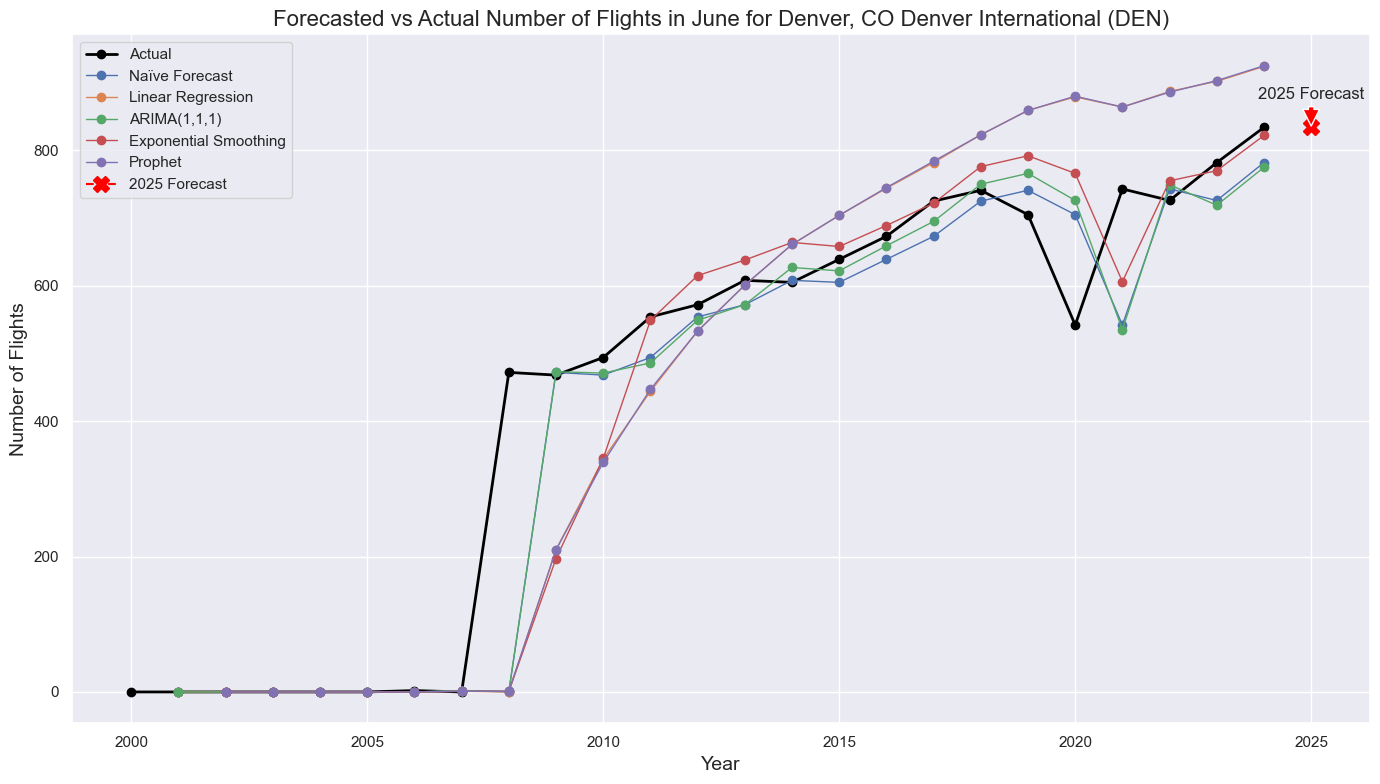

Model Performance Summary:


,Model,MAE,RMSE
0,"ARIMA(1,1,1)",57.391304,57.391304
1,Exponential Smoothing,69.782609,69.782609
2,Linear Regression,98.041667,98.041667
3,Naïve Forecast,53.500000,53.500000
4,Prophet,102.565217,102.565217





Processing Airport: Las Vegas, NV Harry Reid International (LAS)
Loaded data from D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Data/Origin Airport Las Vegas, NV Harry Reid International (LAS).csv successfully.

First few rows of the cleaned DataFrame:


,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Date,Month,Year
0,WN,6/1/2000,117.0,N387,SEA,7:20,7:20,155.0,152.0,0.0,7:38,18.0,0.0,0.0,0.0,0.0,0.0,2000-06-01,6,2000
1,WN,6/1/2000,186.0,N306,LAX,12:00,12:00,70.0,60.0,0.0,12:12,12.0,0.0,0.0,0.0,0.0,0.0,2000-06-01,6,2000
2,WN,6/1/2000,205.0,N311,SAN,19:25,19:30,60.0,60.0,5.0,19:41,11.0,0.0,0.0,0.0,0.0,0.0,2000-06-01,6,2000
3,WN,6/1/2000,274.0,N356,SAN,21:10,21:10,60.0,60.0,0.0,21:22,12.0,0.0,0.0,0.0,0.0,0.0,2000-06-01,6,2000
4,WN,6/1/2000,315.0,N757,LAX,13:35,13:35,65.0,62.0,0.0,13:51,16.0,0.0,0.0,0.0,0.0,0.0,2000-06-01,6,2000



Complete Flights Per Year (June only):


,Year,Number_of_Flights
0,2000,921
1,2001,885
2,2002,843
3,2003,830
4,2004,840
5,2005,831
6,2006,930
7,2007,940
8,2008,969
9,2009,902


23:35:29 - cmdstanpy - INFO - Chain [1] start processing



Processing Year: 2001
Exponential Smoothing failed for year 2001: index 1 is out of bounds for axis 0 with size 1
Prophet model failed for year 2001: Dataframe has less than 2 non-NaN rows.

Processing Year: 2002
ARIMA model failed for year 2002: too many indices for array: array is 0-dimensional, but 1 were indexed


23:35:29 - cmdstanpy - INFO - Chain [1] done processing
23:35:29 - cmdstanpy - INFO - Chain [1] start processing



Processing Year: 2003


23:35:30 - cmdstanpy - INFO - Chain [1] done processing
23:35:30 - cmdstanpy - INFO - Chain [1] start processing



Processing Year: 2004


23:35:32 - cmdstanpy - INFO - Chain [1] done processing
23:35:32 - cmdstanpy - INFO - Chain [1] start processing



Processing Year: 2005


23:35:32 - cmdstanpy - INFO - Chain [1] done processing
23:35:32 - cmdstanpy - INFO - Chain [1] start processing
23:35:32 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2006

Processing Year: 2007


23:35:32 - cmdstanpy - INFO - Chain [1] start processing
23:35:32 - cmdstanpy - INFO - Chain [1] done processing
23:35:32 - cmdstanpy - INFO - Chain [1] start processing
23:35:32 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2008

Processing Year: 2009


23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2010

Processing Year: 2011


23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2012

Processing Year: 2013


23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2014

Processing Year: 2015


23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing
23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2016

Processing Year: 2017


23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing
23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2018

Processing Year: 2019


23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing
23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2020

Processing Year: 2021


23:35:35 - cmdstanpy - INFO - Chain [1] start processing
23:35:35 - cmdstanpy - INFO - Chain [1] done processing
23:35:35 - cmdstanpy - INFO - Chain [1] start processing
23:35:35 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2022

Processing Year: 2023


23:35:35 - cmdstanpy - INFO - Chain [1] start processing
23:35:35 - cmdstanpy - INFO - Chain [1] done processing
23:35:35 - cmdstanpy - INFO - Chain [1] start processing
23:35:35 - cmdstanpy - INFO - Chain [1] done processing



Processing Year: 2024

Forecasting Results:


,Year,Model,Predicted,Actual,MAE,RMSE
0,2001.0,Naïve Forecast,921.0,885.0,36.0,36.0
1,2001.0,Linear Regression,921.0,885.0,36.0,36.0
2,2001.0,"ARIMA(1,1,1)",921.0,885.0,36.0,36.0
3,2001.0,Exponential Smoothing,NaN,885.0,NaN,NaN
4,2001.0,Prophet,NaN,885.0,NaN,NaN
...,...,...,...,...,...,...
115,2024.0,Naïve Forecast,943.0,771.0,172.0,172.0
116,2024.0,Linear Regression,710.0,771.0,61.0,61.0
117,2024.0,"ARIMA(1,1,1)",900.0,771.0,129.0,129.0
118,2024.0,Exponential Smoothing,927.0,771.0,156.0,156.0



Model Performance Summary:


,Model,MAE,RMSE
0,"ARIMA(1,1,1)",88.521739,88.521739
1,Exponential Smoothing,87.652174,87.652174
2,Linear Regression,89.208333,89.208333
3,Naïve Forecast,76.750000,76.750000
4,Prophet,88.565217,88.565217



Best Model for Las Vegas, NV Harry Reid International (LAS): Naïve Forecast with RMSE = 76.75

Forecasting 2025 for Las Vegas, NV Harry Reid International (LAS) using Naïve Forecast...

2025 Predicted Flights for Las Vegas, NV Harry Reid International (LAS): 771
Forecast results saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Las Vegas, NV Harry Reid International (LAS)\Las Vegas, NV Harry Reid International (LAS)_Forecast_Results.csv
Performance summary saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Las Vegas, NV Harry Reid International (LAS)\Las Vegas, NV Harry Reid International (LAS)_Performance_Summary.csv
RMSE plot saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Las Vegas, NV Harry Reid International (LAS)\Las Vegas, NV Harry Reid International (LAS)_Average_RMSE.png
MAE plot saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/Las Vegas, NV Harry Reid International (LAS)\Las Vegas, NV Harry Reid International (LAS)_Average_MAE.png
Pr

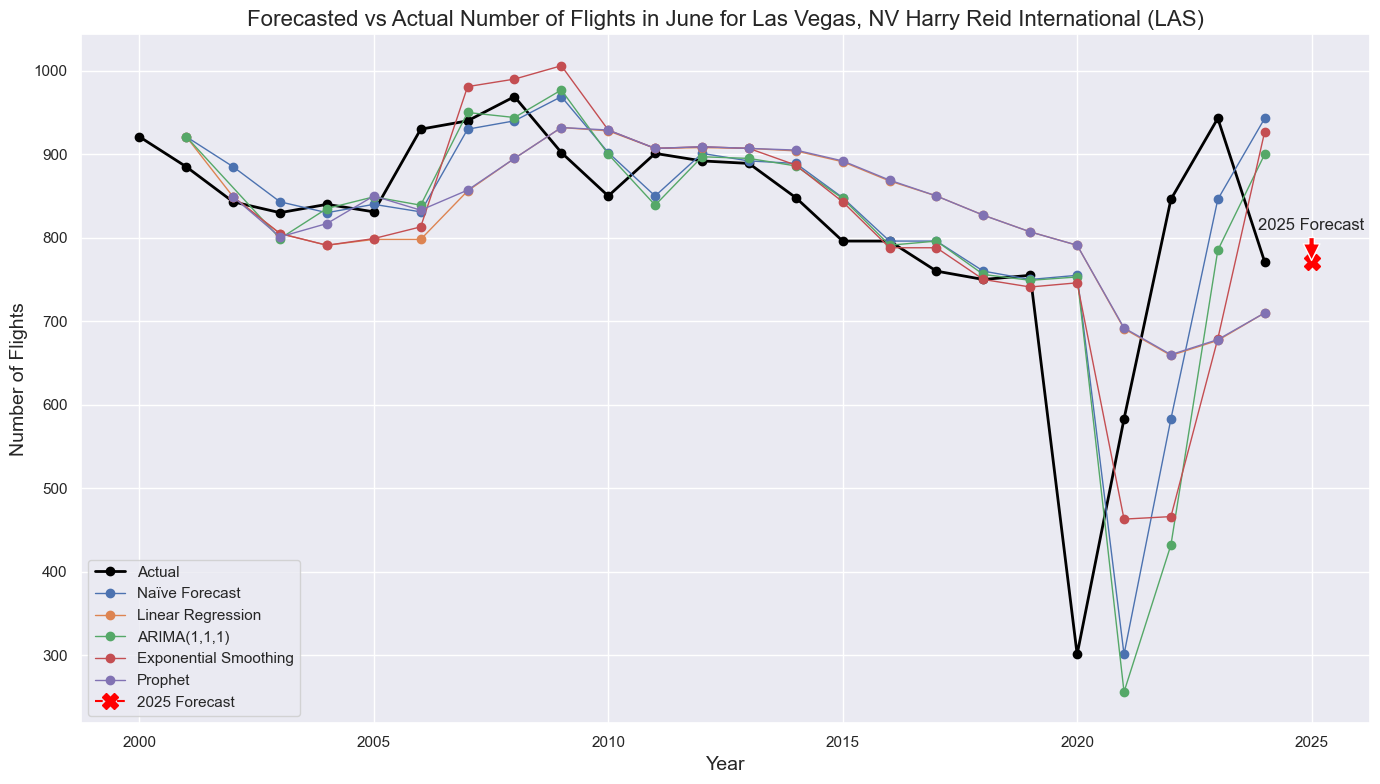

Model Performance Summary:


,Model,MAE,RMSE
0,"ARIMA(1,1,1)",88.521739,88.521739
1,Exponential Smoothing,87.652174,87.652174
2,Linear Regression,89.208333,89.208333
3,Naïve Forecast,76.750000,76.750000
4,Prophet,88.565217,88.565217





=== 2025 Flight Predictions Summary ===


,Airport,2025 Predicted Flights,Model Used
0,"Baltimore, MD BaltimoreWashington Internationa...",375,Naïve Forecast
1,"Chicago, IL Chicago Midway International (MDW)",800,"ARIMA(1,1,1)"
2,"Dallas, TX Dallas Love Field (DAL)",584,Naïve Forecast
3,"Denver, CO Denver International (DEN)",834,Naïve Forecast
4,"Las Vegas, NV Harry Reid International (LAS)",771,Naïve Forecast



Summary table saved to D:/GitHub Repos/630-SOUTHWEST-SCHEDULING/Forecasts/2025_Flight_Predictions_Summary.csv


In [3]:
# Initialize a list to store predictions for 2025
prediction_summary = []

# Iterate through each CSV file and perform forecasting
for csv_file in ff.CSV_FILES:
    # Extract airport name from the filename
    airport_name = csv_file.split('.csv')[0].replace('Origin Airport ', '').strip()
    
    print(f"\n{'='*80}\nProcessing Airport: {airport_name}\n{'='*80}")
    
    # Load data
    filepath = os.path.join(ff.INPUT_DIR, csv_file)
    df_raw = ff.load_data(filepath)
    if df_raw is None:
        print(f"Skipping {airport_name} due to loading issues.")
        continue  # Skip to the next file if loading failed
    
    # Clean and prepare data
    df_clean = ff.clean_and_prepare_data(df_raw, month=ff.FORECAST_MONTH)
    
    # Display first few rows of cleaned data
    print("\nFirst few rows of the cleaned DataFrame:")
    display(df_clean.head())
    
    # Aggregate flights per year
    flights_per_year = ff.aggregate_flights(df_clean)
    
    # Ensure complete years from 2000 to 2024
    all_years = pd.DataFrame({'Year': range(2000, 2025)})
    flights_per_year = pd.merge(all_years, flights_per_year, on='Year', how='left')
    flights_per_year['Number_of_Flights'] = flights_per_year['Number_of_Flights'].fillna(0).astype(int)
    
    print("\nComplete Flights Per Year (June only):")
    display(flights_per_year)
    
    # Perform walk-forward validation
    results = ff.walk_forward_validation(flights_per_year)
    
    # Display forecasting results
    print("\nForecasting Results:")
    display(results)
    
    # Calculate performance summary
    results_clean = results.dropna()
    performance_summary = results_clean.groupby('Model').agg({
        'MAE': 'mean',
        'RMSE': 'mean'
    }).reset_index()
    
    print("\nModel Performance Summary:")
    display(performance_summary)
    
    # Identify the best model based on RMSE
    best_model_row = performance_summary.loc[performance_summary['RMSE'].idxmin()]
    best_model = best_model_row['Model']
    best_rmse = best_model_row['RMSE']
    
    print(f"\nBest Model for {airport_name}: {best_model} with RMSE = {best_rmse:.2f}")
    
    # Forecasting for 2025 Using the Best Model
    print(f"\nForecasting 2025 for {airport_name} using {best_model}...\n")
    
    # Prepare data for forecasting 2025
    # Create a DataFrame for training up to 2024
    train_data_2025 = flights_per_year.copy()
    
    # Depending on the model, fit and forecast accordingly
    if best_model == 'Naïve Forecast':
        # For Naïve Forecast, prediction is the last known value
        prediction_2025 = ff.forecast_naive(train_data_2025)
    elif best_model == 'Linear Regression':
        prediction_2025 = ff.forecast_linear_regression(train_data_2025, test_year=2025)
    elif best_model == 'ARIMA(1,1,1)':
        prediction_2025 = ff.forecast_arima(train_data_2025, test_year=2025)
    elif best_model == 'Exponential Smoothing':
        prediction_2025 = ff.forecast_exponential_smoothing(train_data_2025, test_year=2025)
    elif best_model == 'Prophet':
        prediction_2025 = ff.forecast_prophet(train_data_2025, test_year=2025)
    else:
        print(f"Unknown model: {best_model}. Cannot forecast 2025.")
        prediction_2025 = np.nan
    
    # Handle cases where prediction could not be made
    if np.isnan(prediction_2025):
        print(f"Prediction for 2025 could not be made using {best_model}.")
        prediction_2025_display = "Prediction Failed"
    else:
        prediction_2025_display = int(prediction_2025)
    
    # Append the prediction to the summary table
    prediction_summary.append({
        'Airport': airport_name,
        '2025 Predicted Flights': prediction_2025_display,
        'Model Used': best_model
    })
    
    print(f"2025 Predicted Flights for {airport_name}: {prediction_2025_display}")
    
    # Save forecasting results
    ff.save_forecasts(results, ff.OUTPUT_DIR, airport_name)
    
    # Save performance summary
    airport_output_dir = os.path.join(ff.OUTPUT_DIR, airport_name)
    performance_summary_path = os.path.join(airport_output_dir, f'{airport_name}_Performance_Summary.csv')
    performance_summary.to_csv(performance_summary_path, index=False)
    print(f"Performance summary saved to {performance_summary_path}")
    
    # Visualize performance metrics (saved as images)
    ff.visualize_performance(performance_summary, airport_name, ff.OUTPUT_DIR)
    
    # Visualize predictions vs actuals (saved as images)
    ff.visualize_predictions(results_clean, flights_per_year, airport_name, ff.OUTPUT_DIR)
    
    # -----------------------------------------------
    # **Enhanced Line Plot with Actuals and 2025 Forecast**
    # -----------------------------------------------
    
    # 1. Line Plot with Forecasts (Inline)
    plt.figure(figsize=(14,8))
    
    # Plot Actuals with a distinct color and thicker line
    plt.plot(
        flights_per_year['Year'], 
        flights_per_year['Number_of_Flights'], 
        label='Actual', 
        marker='o', 
        color='black', 
        linewidth=2
    )
    
    # Plot Predictions for each model
    models = results_clean['Model'].unique()
    
    for model in models:
        model_predictions = results_clean[results_clean['Model'] == model][['Year', 'Predicted']]
        plt.plot(
            model_predictions['Year'], 
            model_predictions['Predicted'], 
            label=model, 
            marker='o', 
            linewidth=1
        )
    
    # Plot 2025 Forecast from the Best Model
    if not np.isnan(prediction_2025):
        plt.plot(
            2025, 
            prediction_2025, 
            label='2025 Forecast', 
            marker='X', 
            markersize=12, 
            linestyle='--', 
            color='red'
        )
        plt.annotate(
            '2025 Forecast', 
            xy=(2025, prediction_2025), 
            xytext=(2025, prediction_2025 + (0.05 * prediction_2025)),
            arrowprops=dict(facecolor='red', shrink=0.05), 
            horizontalalignment='center'
        )
    
    plt.title(f'Forecasted vs Actual Number of Flights in June for {airport_name}', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Flights', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 2. Display RMSE and MAE in a Table
    print("Model Performance Summary:")
    display(performance_summary)
    
    # -----------------------------------------------
    # **Optional: Display Separator**
    # -----------------------------------------------
    print("\n" + "="*80 + "\n")

# After the loop, compile the prediction_summary list into a DataFrame
summary_df = pd.DataFrame(prediction_summary)

# Display the summary table
print("\n=== 2025 Flight Predictions Summary ===")
display(summary_df)

# Define the path to save the summary table
summary_table_path = os.path.join(ff.OUTPUT_DIR, '2025_Flight_Predictions_Summary.csv')

# Save the summary DataFrame to CSV
summary_df.to_csv(summary_table_path, index=False)
print(f"\nSummary table saved to {summary_table_path}")
